Install Libraries

In [3]:
!nvidia-smi                                                                      # Displays NVIDIA GPU details (driver, CUDA version, memory usage) to confirm GPU availability

!pip -q install ultralytics opencv-python pycocotools tqdm numpy matplotlib pyyaml onnx onnxruntime
# Installs YOLOv8 (Ultralytics) and dependencies:
#   - opencv-python → image processing
#   - pycocotools → COCO dataset utilities
#   - tqdm → progress bars
#   - numpy → numerical computations
#   - matplotlib → visualizations
#   - pyyaml → read/write YAML config files
#   - onnx / onnxruntime → model export and inference in ONNX format

!pip install roboflow                                                            # Installs Roboflow (for dataset import, preprocessing, and augmentation)




Sun Sep 14 14:48:22 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   48C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [4]:
from roboflow import Roboflow                                                    # Import Roboflow SDK to manage datasets

rf = Roboflow(api_key="gcV6zlStJ3DL9CRwQTAW")                                    # Connect to Roboflow account using your API key

project = rf.workspace("formula-student-driverless-arece-3").project("cone-detection-bldji")
# Access the specific workspace ("formula-student-driverless-arece-3")
# and project ("cone-detection-bldji") where your dataset is stored

version = project.version(6)                                                     # Select dataset version (v6 in this case)

dataset = version.download("yolov5")
# Download the dataset formatted for YOLOv5/YOLOv8 training
# This includes train/val/test images + labels + data.yaml file



loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Cone-detection-6 in yolov5pytorch:: 100%|██████████| 3070/3070 [00:02<00:00, 1055.40it/s]


Install YOLOv8

In [113]:
!pip install ultralytics                                                         # Installs the Ultralytics YOLO package (YOLOv5/YOLOv8 framework for training, validation, and inference)



Train the Model

In [15]:
import yaml                                                                      # Import YAML library to read/write YAML config files

yaml_path = "/content/Cone-detection-6/data.yaml"                                # Path to your dataset config file

with open(yaml_path, "r") as f:
    data_cfg = yaml.safe_load(f)                                                 # Load the YAML file into a Python dictionary

# Fix the dataset paths inside the config (pointing to train/val/test image folders)
data_cfg["train"] = "/content/Cone-detection-6/train/images"
data_cfg["val"]   = "/content/Cone-detection-6/valid/images"
data_cfg["test"]  = "/content/Cone-detection-6/test/images"

with open(yaml_path, "w") as f:
    yaml.safe_dump(data_cfg, f, sort_keys=False)                                 # Save the updated config back to data.yaml

print("✅ Fixed data.yaml")                                                      # Confirmation message

!cat /content/Cone-detection-6/data.yaml                                         # Display the fixed YAML file to verify changes



✅ Fixed data.yaml
names:
- blue_cone
- large_orange_cone
- orange_cone
- unknown_cone
- yellow_cone
nc: 5
roboflow:
  license: CC BY 4.0
  project: cone-detection-bldji
  url: https://universe.roboflow.com/formula-student-driverless-arece-3/cone-detection-bldji/dataset/6
  version: 6
  workspace: formula-student-driverless-arece-3
test: /content/Cone-detection-6/test/images
train: /content/Cone-detection-6/train/images
val: /content/Cone-detection-6/valid/images



🚀 Running exp1_e20_b16_lr0.001_SGD ...
Ultralytics 8.3.199 🚀 Python-3.12.11 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/Cone-detection-6/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=20, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.001, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8s.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=exp1_e20_b16_lr0.001_SGD, nbs=64, nms=False, opset=None, optimize=False, optimizer=SGD, ov

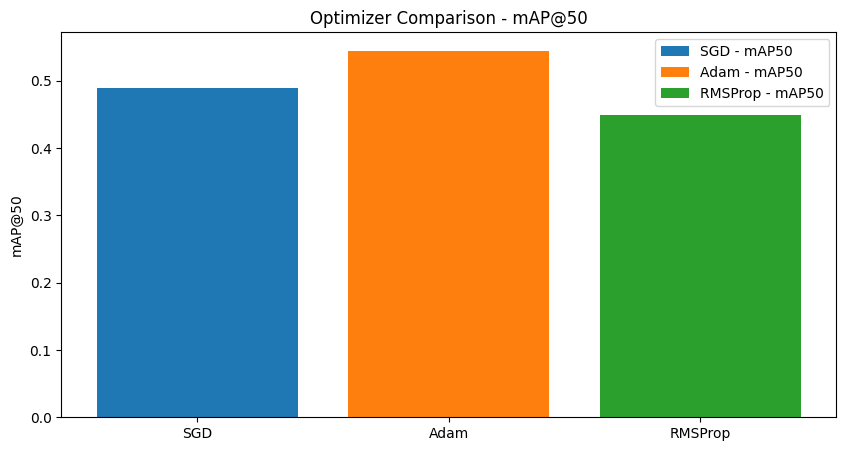

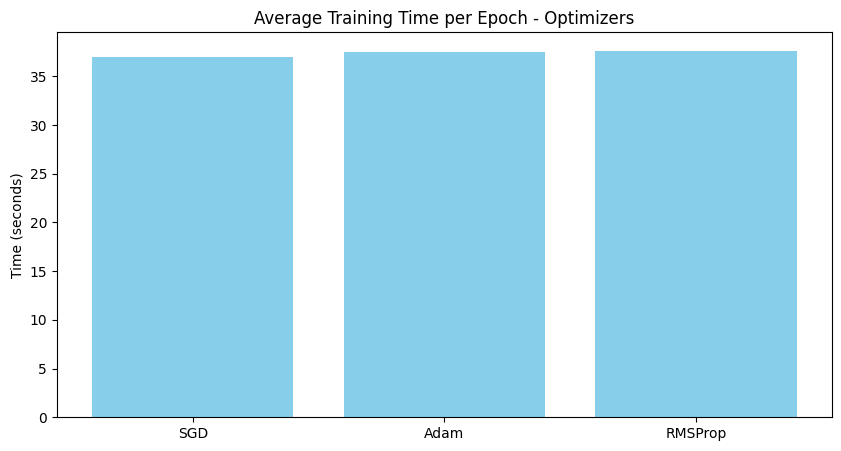

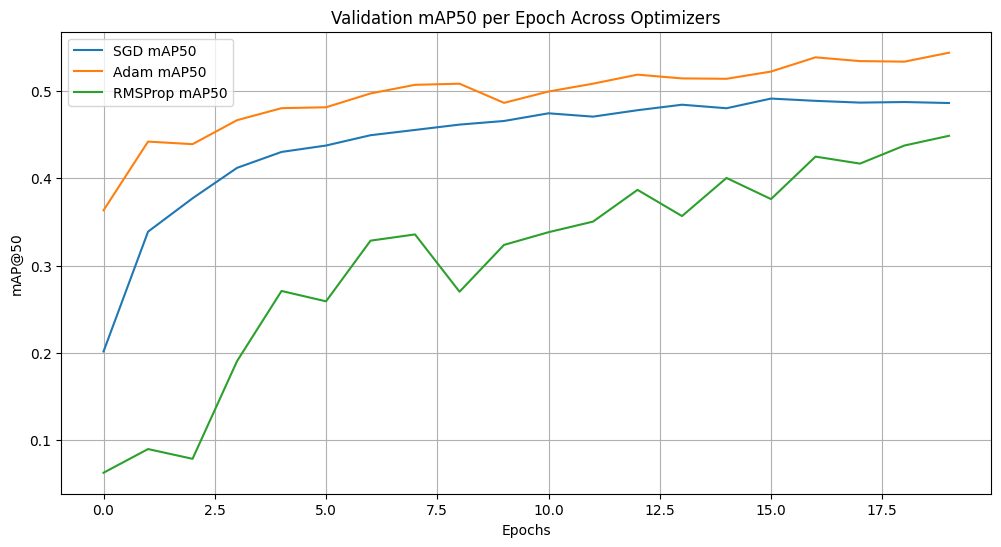

In [97]:
import pandas as pd                 # For handling results tables (dataframes, CSVs)
import matplotlib.pyplot as plt     # For plotting results and comparisons
from ultralytics import YOLO        # Import YOLOv8 model class
import time                         # To measure training time
import os                           # For working with file paths (e.g., results.csv)

# Define experiment configurations (each uses same epochs/batch/lr, but different optimizers)
experiments = [
    {"epochs": 20, "batch": 16, "lr0": 0.001, "optimizer": "SGD"},
    {"epochs": 20, "batch": 16, "lr0": 0.001, "optimizer": "Adam"},
    {"epochs": 20, "batch": 16, "lr0": 0.001, "optimizer": "RMSProp"},
]

results_list = []   # Empty list to collect metrics from all experiments

# Loop through each experiment config
for i, exp in enumerate(experiments, 1):
    run_name = f"exp{i}_e{exp['epochs']}_b{exp['batch']}_lr{exp['lr0']}_{exp['optimizer']}"
    # Unique run name for saving results (e.g., exp1_e20_b16_lr0.001_SGD)

    print(f"\n🚀 Running {run_name} ...")   # Print which experiment is running

    model = YOLO("yolov8s.pt")   # Load a fresh YOLOv8 small model (pretrained on COCO)
    start_time = time.time()     # Start timer to measure training duration

    # Train the model with specified parameters
    model.train(
        data="/content/Cone-detection-6/data.yaml",   # Path to dataset config
        epochs=exp["epochs"],                        # Number of epochs
        imgsz=640,                                   # Input image size
        batch=exp["batch"],                          # Batch size
        lr0=exp["lr0"],                              # Initial learning rate
        optimizer=exp["optimizer"],                  # Optimizer type (SGD/Adam/RMSProp)
        name=run_name                                # Save run under unique name
    )
    end_time = time.time()                           # End timer
    avg_time_per_epoch = (end_time - start_time) / exp["epochs"]   # Calculate avg epoch time

    # Load best weights from training run
    best_weights = f"/content/runs/detect/{run_name}/weights/best.pt"
    best_model = YOLO(best_weights)

    # Validate the model using best weights
    metrics = best_model.val()

    # Collect metrics into dictionary
    per_class_map = metrics.box.maps      # Per-class AP values
    class_names = best_model.names        # Class names from dataset
    row = {
        "Experiment": run_name,
        "Epochs": exp["epochs"],
        "Batch": exp["batch"],
        "LR": exp["lr0"],
        "Optimizer": exp["optimizer"],
        "mAP50": metrics.box.map50,       # Mean Average Precision @ IoU=0.5
        "mAP50-95": metrics.box.map,      # Mean Average Precision @ IoU=0.5–0.95
        "Time_per_epoch": avg_time_per_epoch
    }
    for j, cname in enumerate(class_names):
        row[cname] = per_class_map[j]     # Store per-class mAP values
    results_list.append(row)              # Add results for this run

# Build results table
df_results = pd.DataFrame(results_list)                          # Convert results to DataFrame
df_results.to_csv("cone_experiment_results.csv", index=False)    # Save results as CSV
print("\n✅ Results Table")
print(df_results)

# --- Plot accuracy (mAP50) across optimizers ---
plt.figure(figsize=(10,5))
for opt in df_results["Optimizer"].unique():
    subset = df_results[df_results["Optimizer"] == opt]
    plt.bar(opt, subset["mAP50"].mean(), label=f"{opt} - mAP50")
plt.ylabel("mAP@50")
plt.title("Optimizer Comparison - mAP@50")
plt.legend()
plt.show()

# --- Plot training time per epoch across optimizers ---
plt.figure(figsize=(10,5))
plt.bar(df_results["Optimizer"], df_results["Time_per_epoch"], color="skyblue")
plt.ylabel("Time (seconds)")
plt.title("Average Training Time per Epoch - Optimizers")
plt.show()

# --- Training/validation curves from YOLO logs ---
plt.figure(figsize=(12,6))
for exp in experiments:
    run_name = f"exp{experiments.index(exp)+1}_e{exp['epochs']}_b{exp['batch']}_lr{exp['lr0']}_{exp['optimizer']}"
    results_dir = f"/content/runs/detect/{run_name}"
    results_file = os.path.join(results_dir, "results.csv")

    if os.path.exists(results_file):
        df = pd.read_csv(results_file)   # Load YOLO training logs
        plt.plot(df.index, df["metrics/mAP50(B)"], label=f"{exp['optimizer']} mAP50")
        # Plot validation mAP50 per epoch
    else:
        print(f"⚠️ No results.csv found for {run_name}")

plt.xlabel("Epochs")
plt.ylabel("mAP@50")
plt.title("Validation mAP50 per Epoch Across Optimizers")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
# Compute average per-class mAP (using integer column names)
df_results["avg_class_mAP"] = df_results[[0, 1, 2, 3, 4]].mean(axis=1)

# Find the best run
best_run = df_results.loc[df_results["avg_class_mAP"].idxmax()]
print("🏆 Best parameter combination:")
print(best_run)


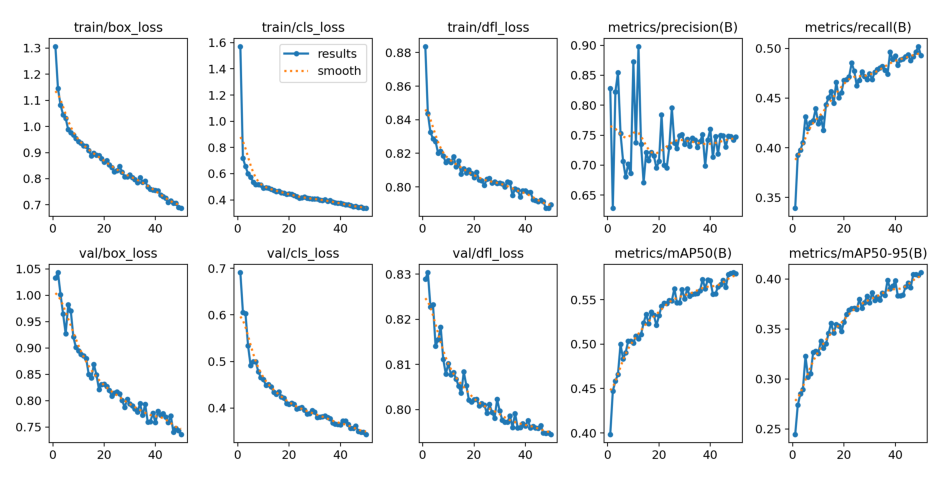

In [112]:
import matplotlib.pyplot as plt   # For plotting and displaying images
import cv2                        # OpenCV library for image loading and processing

img = cv2.imread("/content/runs/detect/cone_yolov8s_run3/results.png")
# Read the YOLO training results image (results.png) from the specified run folder

plt.figure(figsize=(12,8))
# Create a matplotlib figure with a larger size for better visibility

plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
# Convert the OpenCV image (BGR format) to RGB before displaying with matplotlib

plt.axis("off")
# Remove axis ticks and labels for a cleaner display

plt.show()
# Display the image in the output cell





In [21]:
import glob   # Python library for matching file patterns (useful for finding files by name)

val_preds = glob.glob("/content/runs/detect/cone_yolov8s_run3/*_pred.jpg")
# Search the run folder for all prediction images ending with "_pred.jpg"

print(val_preds[:5])
# Print the first 5 file paths found (to quickly check that predictions were saved correctly)


['/content/runs/detect/cone_yolov8s_run3/val_batch1_pred.jpg', '/content/runs/detect/cone_yolov8s_run3/val_batch2_pred.jpg', '/content/runs/detect/cone_yolov8s_run3/val_batch0_pred.jpg']


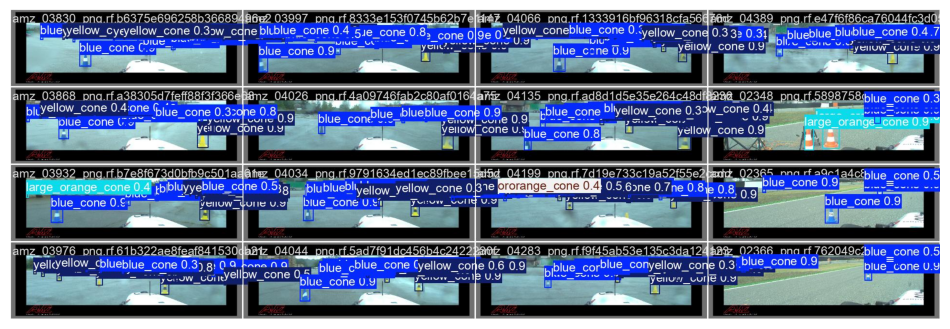

In [22]:
import cv2                        # OpenCV for image reading and processing
import matplotlib.pyplot as plt   # Matplotlib for displaying the image

img = cv2.imread("/content/runs/detect/cone_yolov8s_run3/val_batch0_pred.jpg")
# Load a YOLO validation prediction image (contains detected cones with bounding boxes)

plt.figure(figsize=(12,8))
# Create a matplotlib figure with a custom size for clearer visualization

plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
# Convert the OpenCV image (BGR format) into RGB format before displaying with matplotlib

plt.axis("off")
# Hide axis ticks and labels for a cleaner image display

plt.show()
# Show the prediction image (cones with bounding boxes and class labels)



In [102]:
##from google.colab import files
#files.download(OUT_PATH)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [103]:
from google.colab import files                                                   # Import Colab's files module for handling uploads

uploaded = files.upload()                                                        # Opens a file picker to upload files from your local machine into Colab




Saving fsconetest.mp4 to fsconetest (1).mp4


In [108]:
!ls -lh /content | grep fsconetest.mp4
# List all files in /content with human-readable sizes (-lh),
# then filter the output using grep to only show "fsconetest.mp4"
# → Useful for checking if the video was uploaded successfully and its size




-rw-r--r-- 1 root root 5.2M Sep 14 15:40 fsconetest.mp4


In [109]:
import cv2                          # OpenCV for video processing and drawing
import numpy as np                  # NumPy for numerical operations
from ultralytics import YOLO        # YOLOv8 model from Ultralytics
import collections                  # For deque (to store history of detections)
import subprocess                   # To call ffmpeg for video conversion

# === PATHS ===
MODEL_PATH = "/content/runs/detect/cone_yolov8s_run3/weights/best.pt"   # Trained YOLO model weights
VIDEO_PATH = "/content/fsconetest.mp4"                                  # Input video file
TEMP_PATH  = "/content/temp_output.mp4"                                 # Temporary output (before ffmpeg)
OUT_PATH   = "/content/output_fstest1_centerline.mp4"                   # Final processed video with centerline

# === Load model ===
model = YOLO(MODEL_PATH)   # Load the trained YOLOv8 model

# === Video setup ===
cap = cv2.VideoCapture(VIDEO_PATH)   # Open the input video
fps = cap.get(cv2.CAP_PROP_FPS) or 30   # Get FPS (default to 30 if not found)
w   = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))   # Video width
h   = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))  # Video height

# Define video writer with MP4 codec
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter(TEMP_PATH, fourcc, fps, (w, h))

# Histories (store last 5 frames of cone positions for smoothing)
blue_hist   = collections.deque(maxlen=5)
yellow_hist = collections.deque(maxlen=5)
center_hist = collections.deque(maxlen=5)

# --- Helper: keep only nearest k cones based on y (lower = nearer to camera) ---
def filter_nearest(cones, k=6):
    return sorted(cones, key=lambda p: p[1], reverse=True)[:k]

# === Process video frame by frame ===
while True:
    ret, frame = cap.read()
    if not ret:   # Stop if no frame is returned
        break

    # Run YOLO prediction on current frame
    results = model.predict(frame, conf=0.25, verbose=False)
    det = results[0]

    blue_pts, yellow_pts, orange_pts = [], [], []   # Store cone detections

    # If there are detections
    if det.boxes is not None and len(det.boxes) > 0:
        boxes = det.boxes.xyxy.cpu().numpy()             # Bounding box coords
        clses = det.boxes.cls.cpu().numpy().astype(int)  # Class IDs

        for (x1,y1,x2,y2), cls in zip(boxes, clses):
            cx, cy = int((x1+x2)/2), int((y1+y2)/2)   # Center point of box
            label = model.names[cls]                  # Get class label

            # Ignore far or very small detections
            if cy < h*0.3:
                continue
            if (x2-x1) * (y2-y1) < 100:
                continue

            # Classify and store points by cone type
            if label == "blue_cone":
                blue_pts.append((cx,cy)); color=(255,0,0)
            elif label == "yellow_cone":
                yellow_pts.append((cx,cy)); color=(0,255,255)
            elif label in ["orange_cone","large_orange_cone"]:
                orange_pts.append((cx,cy)); color=(0,165,255)
            else:
                color=(200,200,200)   # Unknown cone

            # Draw cone center and label on frame
            cv2.circle(frame,(cx,cy),4,color,-1)
            cv2.putText(frame, label, (cx, cy-10),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

    # Update history buffers
    if blue_pts: blue_hist.append(blue_pts)
    if yellow_pts: yellow_hist.append(yellow_pts)

    # --- Draw smoothed boundaries ---
    blue_draw   = filter_nearest(blue_hist[-1]) if blue_hist else []
    yellow_draw = filter_nearest(yellow_hist[-1]) if yellow_hist else []

    # --- Blue cones (polyline along nearest detections) ---
    if blue_draw:
        cv2.polylines(frame, [np.array(blue_draw, dtype=np.int32)], False, (255,0,0), 2)

    # --- Yellow cones (polyline + circles + labels) ---
    if yellow_pts:
        cv2.polylines(frame, [np.array(yellow_pts, dtype=np.int32)], False, (0,255,255), 2)
        for (x,y) in yellow_pts:
            cv2.circle(frame,(x,y),8,(0,255,255),-1)
            cv2.putText(frame, "yellow", (x, y-10),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,255,255), 2)

    # --- Orange cones (polyline + circles + labels) ---
    if orange_pts:
        cv2.polylines(frame, [np.array(orange_pts, dtype=np.int32)], False, (0,165,255), 2)
        for (x,y) in orange_pts:
            cv2.circle(frame,(x,y),8,(0,165,255),-1)
            cv2.putText(frame, "orange", (x, y-10),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,165,255), 2)

    # --- Central line between blue and yellow cones ---
    center_pts = []
    if blue_draw and yellow_draw:
        for (bx,by), (yx,yy) in zip(blue_draw, yellow_draw):
            mx, my = int((bx+yx)/2), int((by+yy)/2)   # Midpoint between blue & yellow cone
            center_pts.append((mx,my))

    if center_pts:
        center_hist.append(center_pts)   # Add to history for smoothing
        smoothed = np.mean(np.array(center_hist, dtype=np.float32), axis=0).astype(int)
        cv2.polylines(frame, [smoothed], False, (0,255,0), 2)   # Draw smoothed centerline in green

    # Write processed frame to output video
    out.write(frame)

# Release video objects
cap.release()
out.release()

# --- Convert MP4 to a more compatible codec (H.264) ---
subprocess.run(["ffmpeg", "-y", "-i", TEMP_PATH, "-vcodec", "libx264", OUT_PATH])
print("✅ Saved video:", OUT_PATH)



✅ Saved video with central line: /content/output_fstest1_centerline.mp4


In [110]:
from google.colab import files                                                   # Import Colab's file handling utilities

files.download(OUT_PATH)                                                         # Download the processed video (with centerline) to your local machine


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>